# Figure 2

Behavioral experiment results. \textbf{A}: Average score as a function of the average number of times a player attends the bar. \textbf{B}: Learning dynamics within and across sessions. \textbf{C}: Relationship between bounded efficiency and bounded inequality, with shaded ovals indicating distinct coordination patterns. \textbf{D}: Influence of threshold and group size on bounded efficiency. \textbf{E}: Impact of grid structure on efficiency and of threshold changes on efficiency direction. \textbf{F}: Representative game trajectories achieving the highest efficiency.

In [2]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import PIL
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from pathlib import Path
from scipy.stats import pearsonr
from collections import defaultdict
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements
from Utils.bar_utils import BarRenderer

### Loading and preprocessing data

In [26]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions

group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)


def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

def get_context(num_players):
    if num_players == 2:
        return 'Two'
    elif num_players == 3:
        return 'Three'
    else:
        return 'Bigger'

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
data['context'] = data['num_players'].apply(lambda x: get_context(x))

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))
data.head(2)

Loading data from /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...
Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


,source,treatment,group,round,player,score,threshold,num_players,decision,model,session,context
0,humans,score + grid,0001,0,405186428721292,0.0,0.5,2,0,Grupo-0001-2-0.50,1,Two
1,humans,score + grid,0001,0,728608683559397,1.0,0.5,2,1,Grupo-0001-2-0.50,1,Two


In [14]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality', 'bounded_inequality'],
    T=15
)
df = gm.get_measurements()

### Panel A --- Individual incentives vs. Group benefit

In [15]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

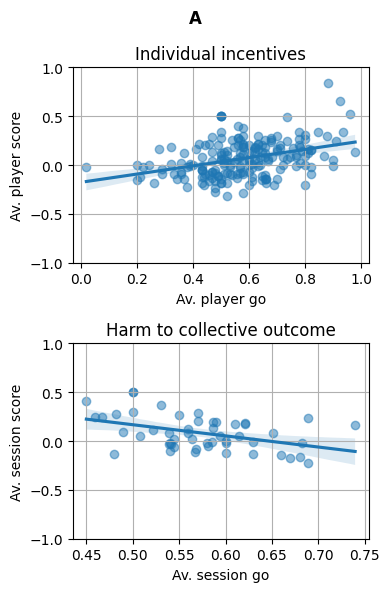

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), tight_layout=True)

# Individual incentives
sns.regplot(
    x='decision', y='score',
    scatter_kws={'alpha': 0.5}, 
    data=player_av_scores, ax=ax[0]
)
ax[0].set_xlabel("Av. player go")
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Individual incentives")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Harm to collective outcome

sns.regplot(
    x='decision', y='score', 
    scatter_kws={'alpha': 0.5}, 
    data=group_av_scores, ax=ax[1]
)
ax[1].set_xlabel("Av. session go")
ax[1].set_ylabel("Av. session score")
ax[1].set_title("Harm to collective outcome")
ax[1].grid()
ax[1].set_ylim([-1,1])

# Convert figure to image array
fig.suptitle("A", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_A = np.array(pil_image)

Pearson coefficients per player

In [33]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: 0.3705
P-value: 7.7511e-08
0.370 (p=0.000)


Pearson coefficients per group

In [34]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: -0.4331
P-value: 1.5028e-03
-0.433 (p=0.002)


### Panel B --- Influence of threshold and number of players

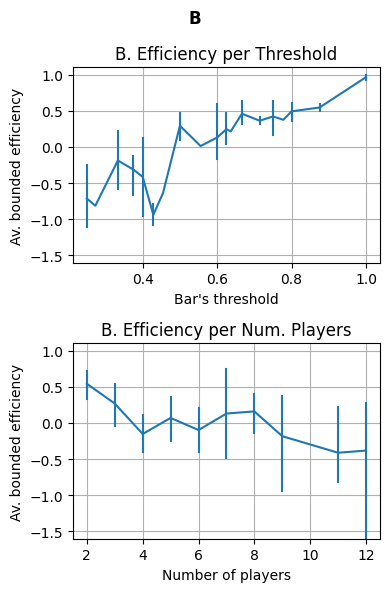

In [20]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(4,6), 
    tight_layout=True,
    # sharex=True, sharey=True
)

# Efficiency per threshold and treatment
sns.lineplot(
    x='threshold', y='bounded_efficiency',
    data=df, ax=ax[0],
    err_style="bars",
    errorbar="ci",
    palette='icefire'
)
ax[0].set_xlabel("Bar's threshold")
ax[0].set_ylabel("Av. bounded efficiency")
ax[0].set_title("B. Efficiency per Threshold")
ax[0].grid()
ax[0].set_ylim([-1.6,1.1])

# Efficiency per number of agents and treatment
sns.lineplot(
    x='num_players', y='bounded_efficiency',
    data=df, ax=ax[1],
    err_style="bars",
    errorbar="ci",
    palette='icefire'
)
ax[1].set_xlabel("Number of players")
ax[1].set_ylabel("Av. bounded efficiency")
ax[1].set_title("B. Efficiency per Num. Players")
ax[1].grid()
ax[1].set_ylim([-1.6,1.1])


# Convert figure to image array
fig.suptitle("B", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_B = np.array(pil_image)

### Panel C --- Score per round vs per session

In [21]:
def get_threshold_level(x:float) -> str:
    q = math.floor(x * 4 + 0.5) / 4.0   # redondeo a múltiplos de 0.25, half-up
    level = max(0.25, q)
    if level < 0.5:
        return 'low'
    elif level == 0.5:
        return 'middle'
    else:
        return 'high'

data_MP = data[data['num_players'] > 2]
data_MP['thresh_level'] = data_MP['threshold'].apply(get_threshold_level)
MP_group_av_scores = group_av_scores = data_MP.groupby(['treatment', 'group', 'threshold', 'thresh_level']).agg({
    'score':'mean',
    'decision':'mean'
}).reset_index()
MP_group_av_scores['bounded_efficiency'] = MP_group_av_scores['score'] / MP_group_av_scores['threshold']

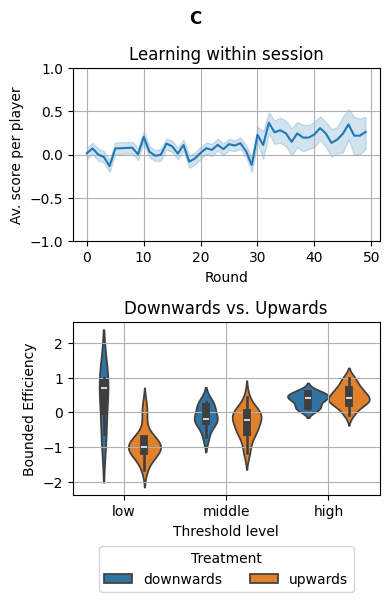

In [29]:
fig, ax = plt.subplots(
    2,1, 
    figsize=(4,6), 
    tight_layout=True,
    sharey=False
)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', 
    # hue='context', style='context',
    data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. score per player")
ax[0].set_title("Learning within session")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Distribution of efficiency vs treatment in Multi-player experiment
sns.violinplot(
    x='thresh_level', y='bounded_efficiency', hue='treatment',
    data=MP_group_av_scores, ax=ax[1], 
    order=['low', 'middle', 'high'],
    hue_order=['downwards', 'upwards'],
)
# sns.swarmplot(
#     x='thresh_level', y='score', hue='treatment', color='black',   
#     data=MP_group_av_scores, ax=ax[1],
# )
ax[1].set_xlabel('Threshold level')
ax[1].set_ylabel('Bounded Efficiency')
ax[1].set_title('Downwards vs. Upwards')
ax[1].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.6),
    ncol=2
)
ax[1].grid()

# Convert figure to image array
fig.suptitle("C", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_C = np.array(pil_image)

Pearson round vs score

In [36]:
pearson_coef, p_value = stats.pearsonr(data['score'], data['round'])

print(f"Pearson correlation coefficient: {pearson_coef}")
print(f"P-value: {p_value}")
print(f"{pearson_coef:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: 0.058196147189806514
P-value: 1.8069066508605595e-13
0.058 (p=0.000)


### Panels A, B and C 

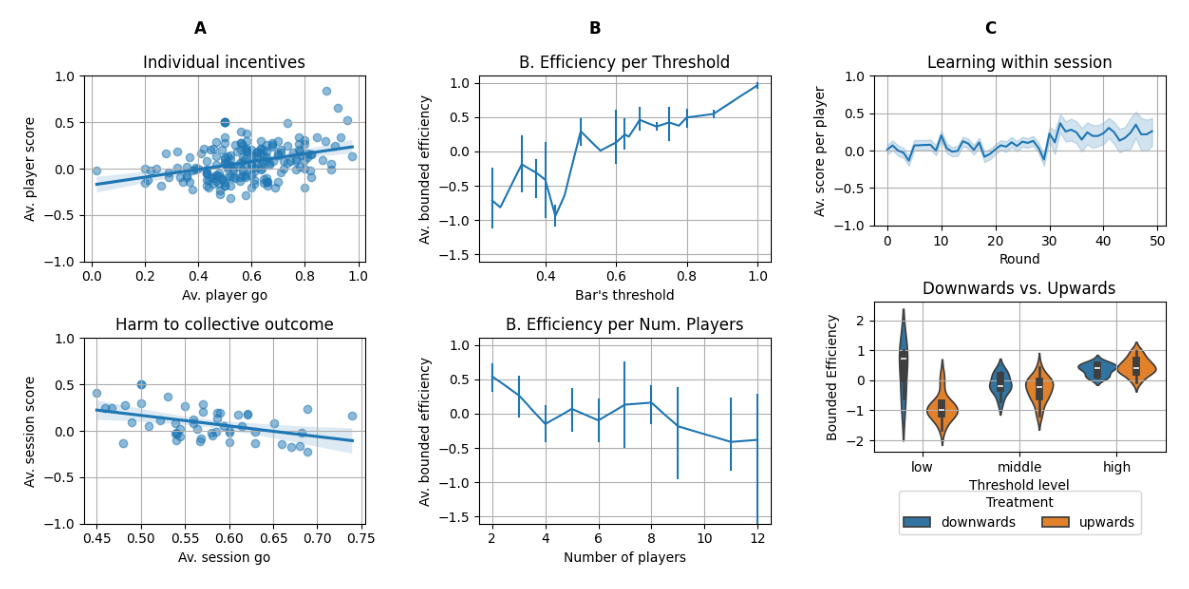

In [30]:
# fig = plt.figure(figsize=(12, 6), tight_layout=True)  # total width = 4 + 8 = 12, height = 6
# gs = gridspec.GridSpec(1, 12, figure=fig)  # 12 columns, 1 row

# ax1 = fig.add_subplot(gs[0, 0:4])
# ax1.imshow(panel_A)  

# ax2 = fig.add_subplot(gs[0, 4:12])
# ax2.imshow(panel_B)

# ax1.axis('off')
# ax2.axis('off')

fig, ax = plt.subplots(1, 3, figsize=(12,6), tight_layout=True)

ax[0].imshow(panel_A)  
ax[1].imshow(panel_B)
ax[2].imshow(panel_C)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B_C = np.array(pil_image)

### Panel D --- Bounded efficiency vs. Bounded inequality

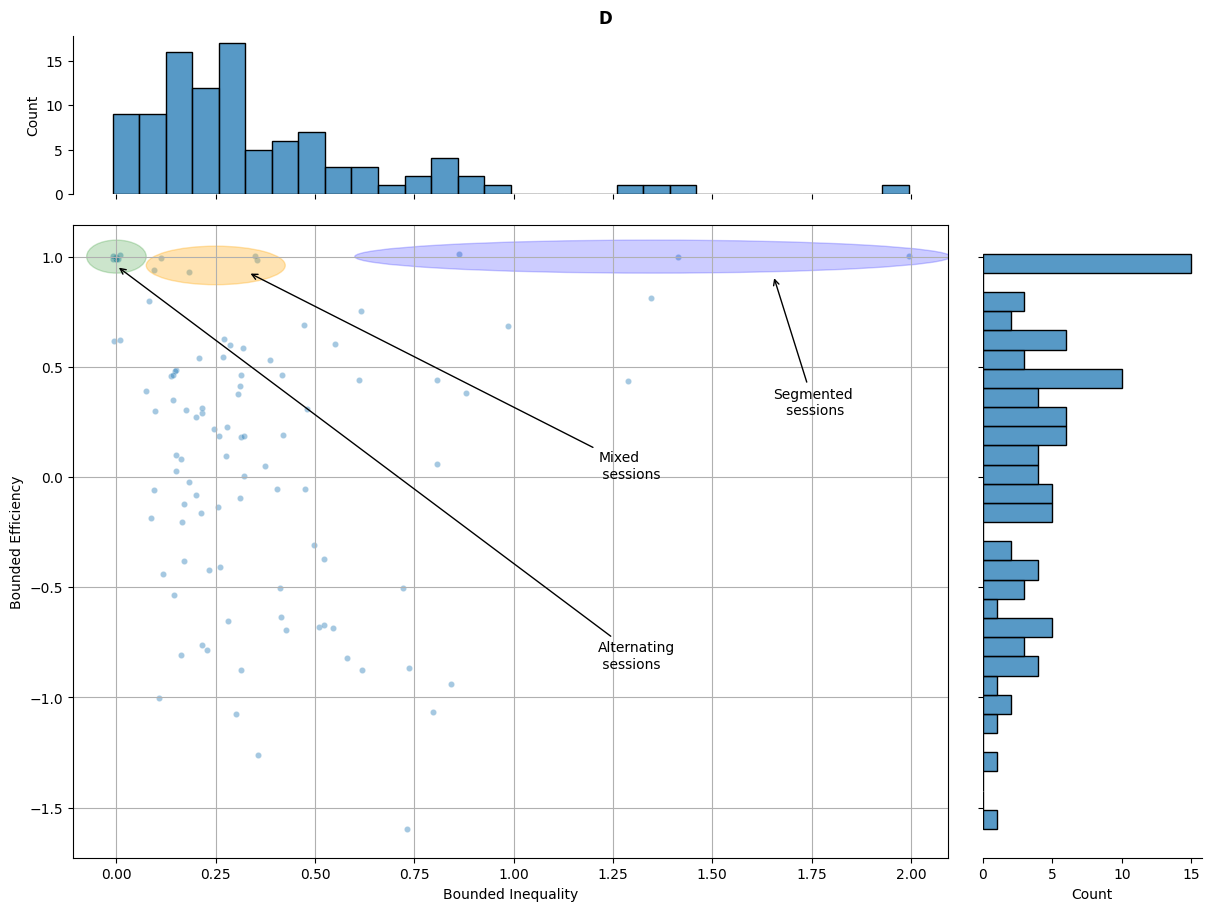

In [33]:
df_jitter = df.copy()
n = df_jitter.shape[0]
sigma = 0.0075
df_jitter['bounded_inequality'] = df_jitter['bounded_inequality'] + np.random.normal(0, sigma, n)
df_jitter['bounded_efficiency'] = df_jitter['bounded_efficiency'] + np.random.normal(0, sigma, n)

fig = plt.figure(figsize=(12,9), constrained_layout=True)

# One “slot” in a larger layout could be outer[0]; here we just show the joint block
gs_outer = fig.add_gridspec(1, 1)
gs = gs_outer[0].subgridspec(
    2, 2, height_ratios=[1, 4], width_ratios=[4, 1],
    hspace=0.05, wspace=0.05
)

ax_joint  = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# Joint (scatter)
sns.scatterplot(
    x='bounded_inequality', y='bounded_efficiency',
    # style='predicted_class', hue='predicted_class',
    data=df_jitter,
    # hue='treatment', style='num_players',
    alpha=0.4, ax=ax_joint,
    palette='icefire',
    s=20
)
ax_joint.grid()

# Marginals (histograms)
sns.histplot(data=df_jitter, x='bounded_inequality', ax=ax_marg_x, bins=30)
sns.histplot(data=df_jitter, y='bounded_efficiency', ax=ax_marg_y, bins=30)

# Tidy up the marginal axes
ax_marg_x.tick_params(axis="x", labelbottom=False)
ax_marg_x.set_xlabel('')

ax_marg_y.tick_params(axis="y", labelleft=False)
ax_marg_y.set_ylabel('')

sns.despine(ax=ax_marg_x, bottom=True)
sns.despine(ax=ax_marg_y, left=True)

# Labels (now this is a normal Matplotlib figure you control)
ax_joint.set_xlabel("Bounded Inequality")
ax_joint.set_ylabel("Bounded Efficiency")

# Show the alternating groups on the top-left corner
circle = patches.Ellipse(
    (0, 1), width=0.15, height=0.15,
    # transform=ax_joint.transAxes, 
    color='green', alpha=0.2, 
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Alternating\n sessions',
    xy=(0.05, 0.935), xycoords='axes fraction',
    xytext=(0.6, 0.3), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the mixed groups on the top center
circle = patches.Ellipse(
    (0.25, 0.96), width=0.35, height=0.175,
    # transform=ax.transAxes, 
    color='orange', alpha=0.3, 
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Mixed\n sessions',
    xy=(0.2, 0.925), xycoords='axes fraction',
    xytext=(0.6, 0.6), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the segmented groups on the top-right corner
circle = patches.Ellipse(
    (1.35, 1), width=1.5, height=0.15, 
    # transform=ax.transAxes, 
    color='blue', alpha=0.2
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Segmented\n   sessions',
    xy=(0.8, 0.92), xycoords='axes fraction',
    xytext=(0.8, 0.7), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Convert figure to image array
fig.suptitle("D", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_D = np.array(pil_image)

In [34]:
print(df['bounded_efficiency'].describe())

count    101.000000
mean       0.114013
std        0.635898
min       -1.604167
25%       -0.375000
50%        0.214286
75%        0.589286
max        1.000000
Name: bounded_efficiency, dtype: float64


In [35]:
df[df['bounded_efficiency'] > 0].size / df.size

0.6138613861386139

In [36]:
print(df['bounded_inequality'].describe())

count    101.000000
mean       0.362896
std        0.330662
min        0.000000
25%        0.157288
50%        0.276214
75%        0.471865
max        2.000000
Name: bounded_inequality, dtype: float64


# Panels A to D

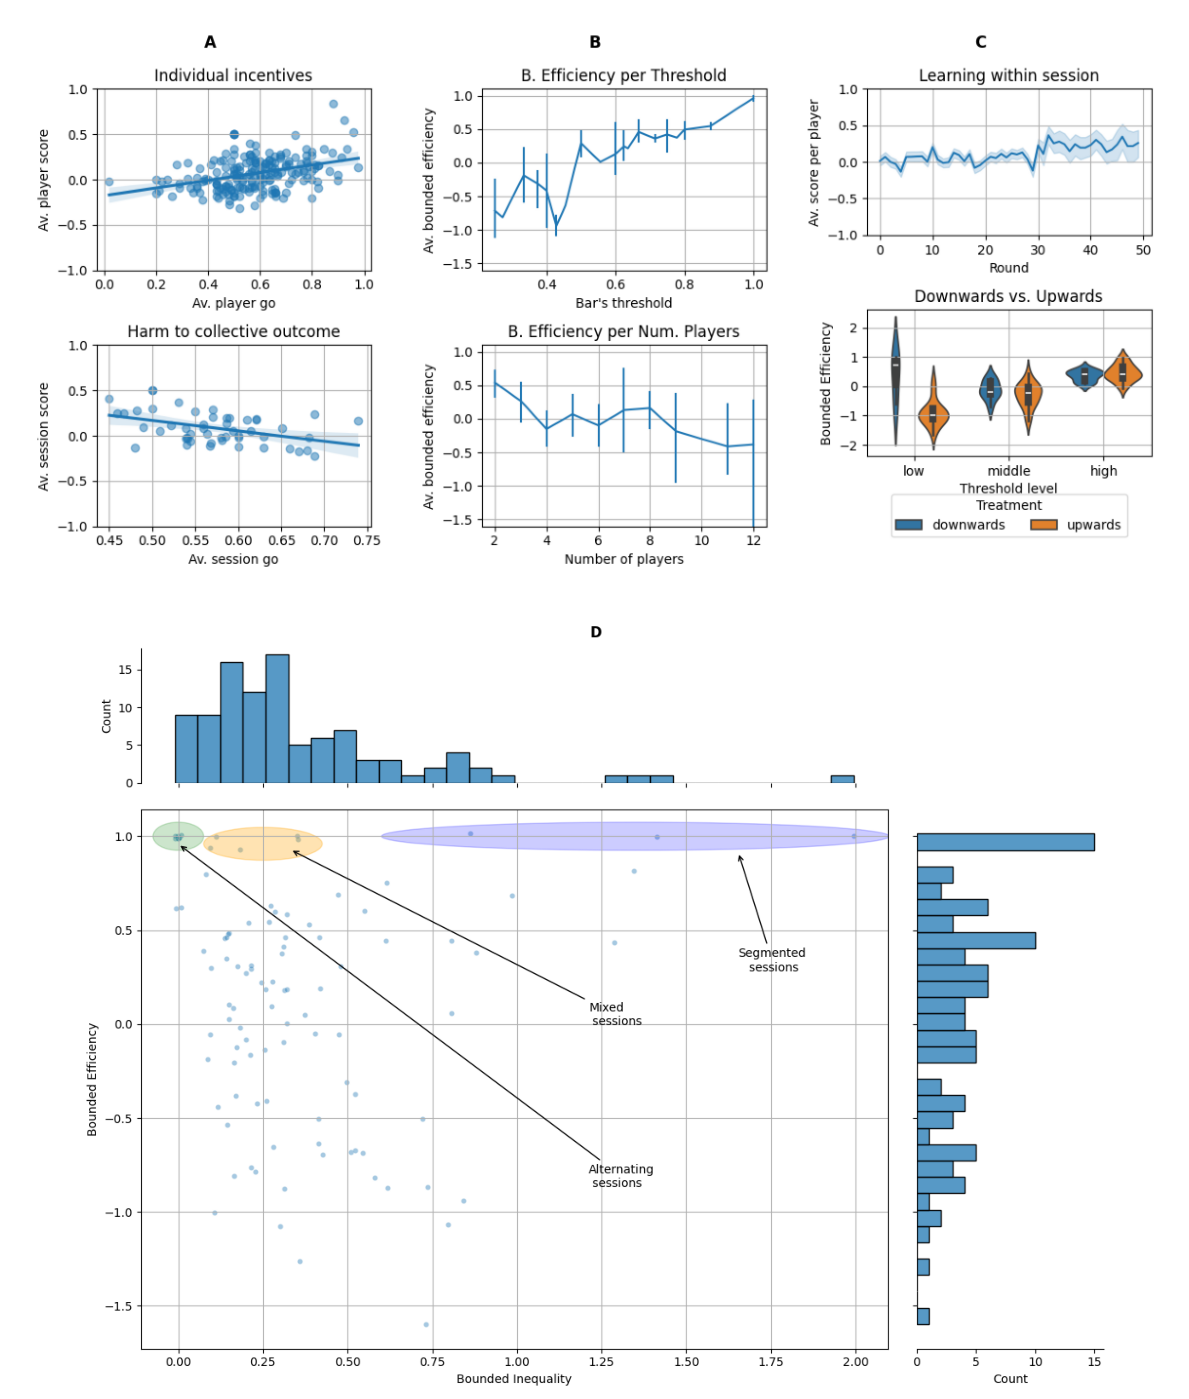

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(12,15), tight_layout=True)

ax[0].imshow(panels_A_B_C)  
ax[1].imshow(panel_D)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B_C_D = np.array(pil_image)

### Panel E --- Examples of playouts

In [41]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

Loading data from /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...


In [42]:
# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions
    
group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)

def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))

Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


In [43]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality', 'bounded_inequality'],
    T=25
)
df = gm.get_measurements()

# Find coordination type
alt_index = AlternationIndex.from_file(priority='mlp')
df['predicted_class'] = alt_index.classify(df)

In [44]:
df_best = df[df['bounded_efficiency'] > 0.5]
df_best = df_best[df_best['threshold'] < 1]

# df_best['model'] = df_best.apply(lambda row: f"{row['model']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
df_best.sort_values(by=['bounded_efficiency', 'num_players'], ascending=False, inplace=True)
print('Num. of best sessions:', len(df_best))
# df_best

Num. of best sessions: 27


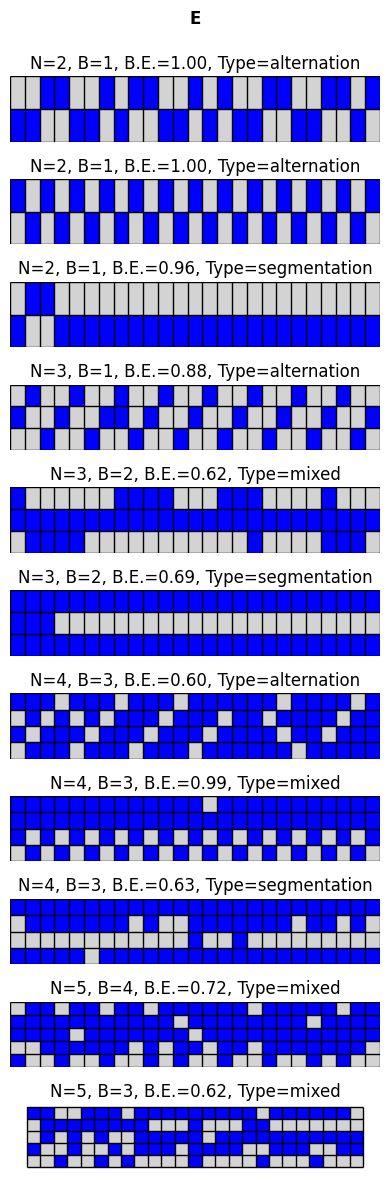

In [50]:
# groups = df_best['model'].unique()
keep_groups_idx = [
    4, 3, 7, 8, 20, 16, 21, 5, 18, 14, 19, # 22
]
groups = np.array(df_best['model'].unique())[keep_groups_idx].tolist()
categories = [
    'alternation', 'alternation', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'mixed', 'mixed', # 'mixed'
]

fig, axes = plt.subplots(
    11, 1, 
    figsize=(4, 12),
    tight_layout=True
)

for i, group in enumerate(groups):
    df_aux = df_best[df_best['model'] == group]
    df_aux_aux = data[data['model'] == group]
    threshold = df_aux['threshold'].unique()[0]
    BE = df_aux['bounded_efficiency'].unique()[0]
    N = df_aux_aux['num_players'].values[0]
    B = int(df_aux_aux['threshold'].values[0] * N)
    # classification = df_aux['predicted_class'].values[0]
    classification = categories[i]
    # classification = i
    bar_renderer = BarRenderer(data=df_aux_aux)
    bar_renderer.render(
        ax=axes[i],
        title=f"N={N}, B={B}, B.E.={BE:.2f}, Type={classification}",
        num_rounds=25
    )

# Convert figure to image array
fig.suptitle("E\n", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_E = np.array(pil_image)

### All panels

(np.float64(-0.5), np.float64(399.5), np.float64(1199.5), np.float64(-0.5))

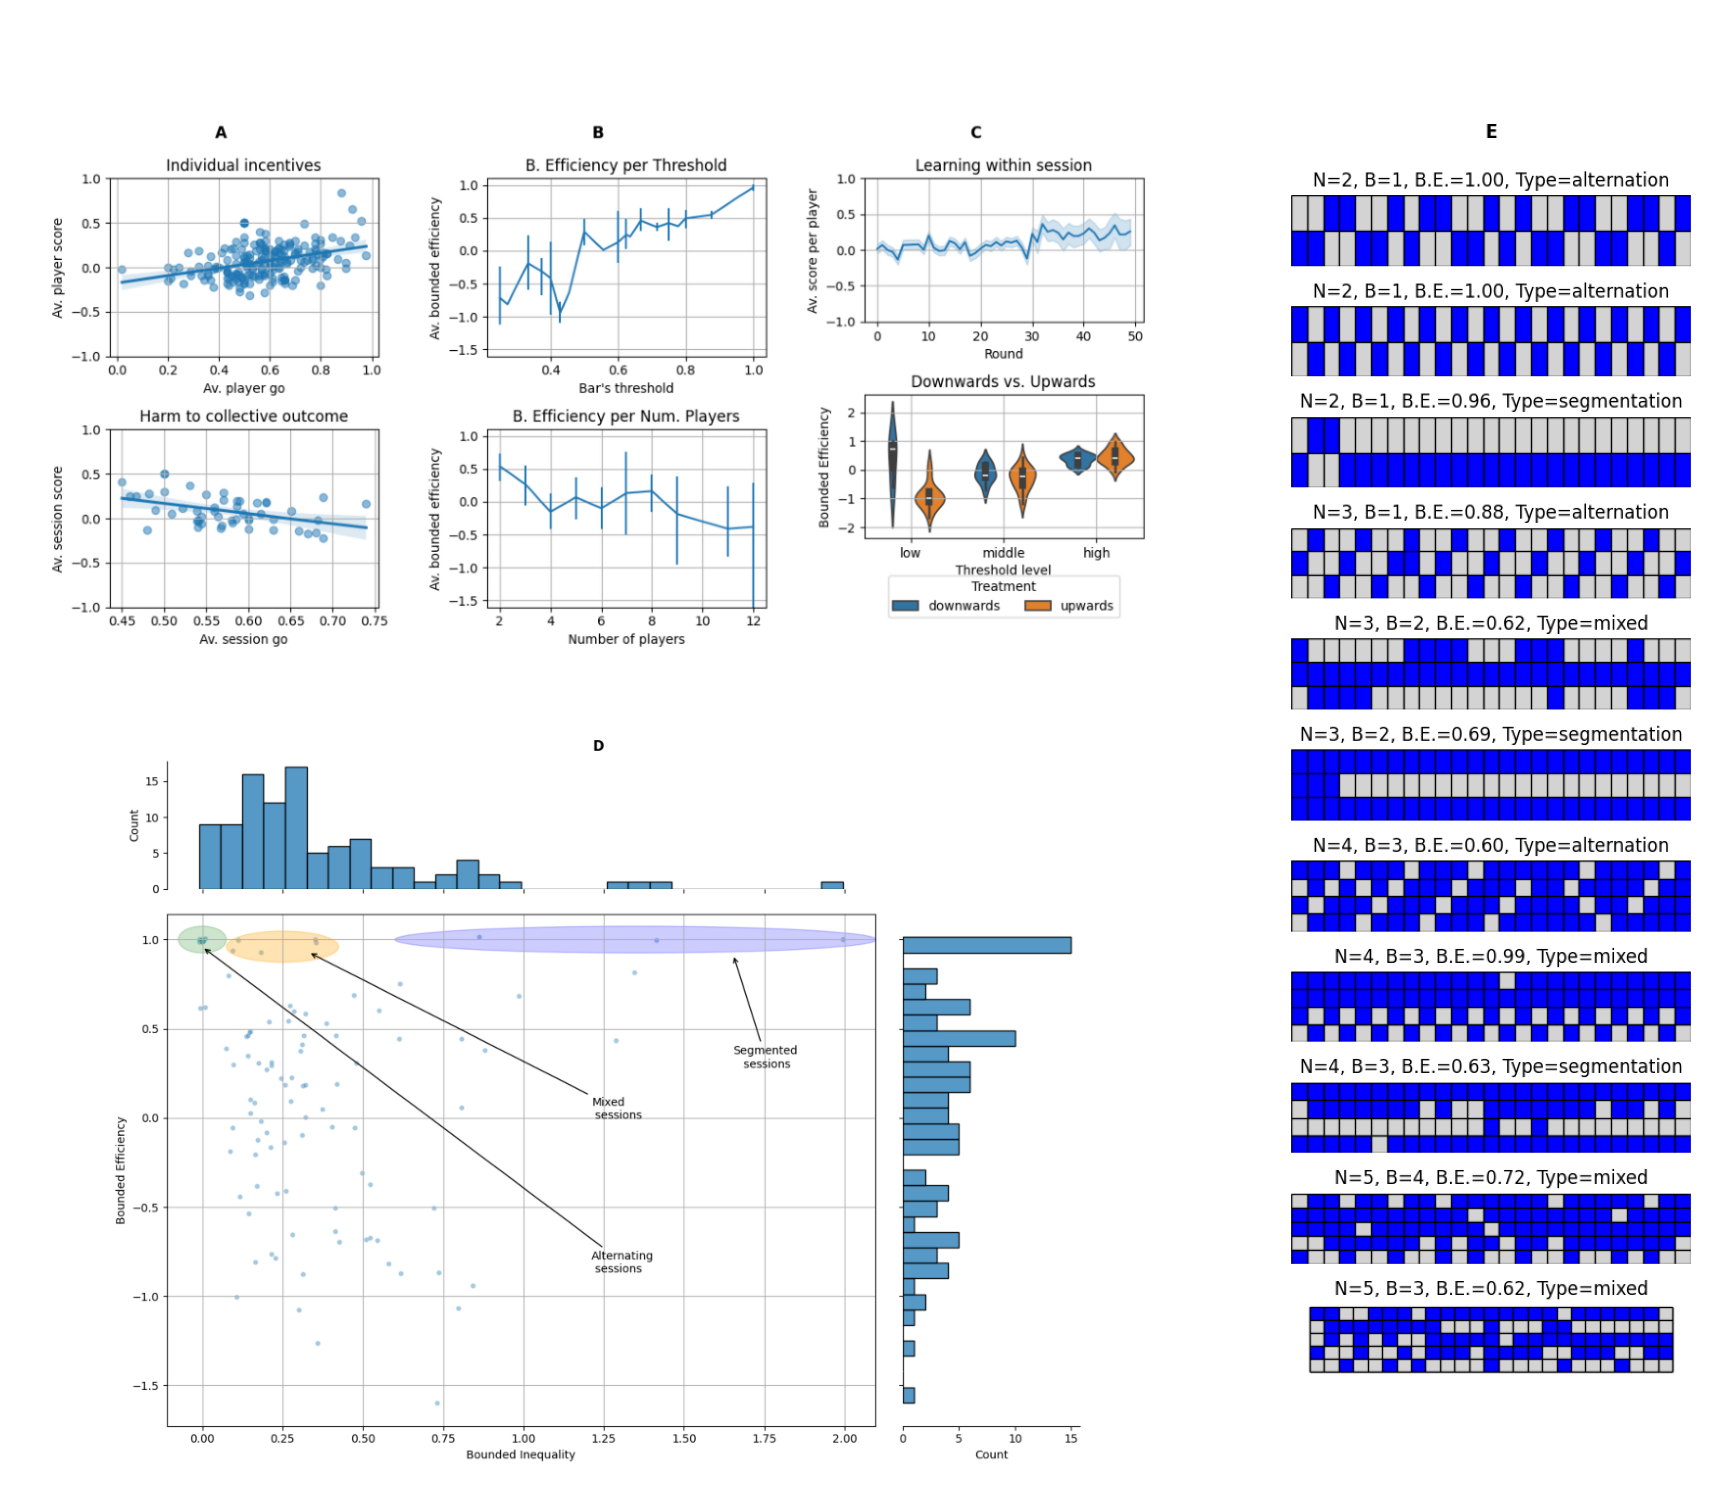

In [51]:
fig = plt.figure(figsize=(18, 15), tight_layout=True)  
gs = gridspec.GridSpec(1, 4, figure=fig)  

ax1 = fig.add_subplot(gs[0, 0:3])
ax1.imshow(panels_A_B_C_D)  

ax2 = fig.add_subplot(gs[0, 3:4])
ax2.imshow(panel_E)

ax1.axis('off')
ax2.axis('off')

In [ ]:
fig.savefig(PATHS['figures_for_paper'] / 'Short_Fig2.png', dpi=300, bbox_inches='tight')

---

### Regressions

In [5]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality'],
)
gm.columns.append('session')
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)

df.head(2)

,model,treatment,threshold,num_players,group,session,efficiency,bounded_efficiency,entropy,conditional_entropy,inequality,alternation_index
0,11-8-0.38,downwards,0.375,8,11,3,-0.073276,-0.195402,0.590006,0.017857,0.101689,0.000750
1,11-8-0.62,downwards,0.625,8,11,2,0.072581,0.116129,0.540606,0.072957,0.129893,0.000219


In [6]:
formula = 'bounded_efficiency ~ num_players + threshold + num_players * threshold'
lm = ols(formula, df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     bounded_efficiency   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     40.61
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           4.35e-17
Time:                        10:50:07   Log-Likelihood:                -51.853
No. Observations:                 101   AIC:                             111.7
Df Residuals:                      97   BIC:                             122.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.75

In [9]:
formula = 'bounded_efficiency ~ num_players + threshold + treatment + session'
# formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df[df['num_players'] > 2]).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     bounded_efficiency   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     49.12
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           5.46e-20
Time:                        10:52:38   Log-Likelihood:                -24.546
No. Observations:                  78   AIC:                             59.09
Df Residuals:                      73   BIC:                             70.88
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2366 

In [13]:
formula = 'bounded_efficiency ~ num_players + threshold + treatment + session'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
formula += '+ session * treatment + session * threshold + session * num_players'
lm = ols(formula, df[df['num_players'] > 2]).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     bounded_efficiency   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     24.43
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.22e-18
Time:                        10:55:07   Log-Likelihood:                -15.572
No. Observations:                  78   AIC:                             53.14
Df Residuals:                      67   BIC:                             79.07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [67]:
formula = 'alternation_index ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      alternation_index   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     5.967
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.72e-06
Time:                        10:23:11   Log-Likelihood:                 19.349
No. Observations:                 101   AIC:                            -20.70
Df Residuals:                      92   BIC:                             2.838
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Check collective action dilemma

In [ ]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

In [ ]:
from scipy.stats import pearsonr

In [ ]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

In [ ]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

---